<a href="https://colab.research.google.com/github/codewithhari98/Machine_Learning/blob/main/Gesture_recognition_HMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
https://sequentia.readthedocs.io/en/latest/sections/classifiers/gmmhmm.html </br>
https://colab.research.google.com/github/davidletscher/talks/blob/master/HMM.ipynb#scrollTo=XldqHtwl2Ihf </br>
https://dillhoffaj.utasites.cloud/posts/hidden_markov_models/ </br>
https://hmmlearn.readthedocs.io/en/latest/ </br>
https://hmmlearn.readthedocs.io/en/latest/tutorial.html

In [ ]:
!pip install hmmlearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
import pickle

## Accessing the Downloaded Dataset

In [ ]:
gesture_df = pd.read_csv('Original_Dataset.csv')
print(gesture_df)

     LC_X_1  LC_X_2  LC_X_3  LC_X_4  LC_X_5  LC_X_6  LC_X_7  LC_X_8  LC_X_9  \
0       307     389     259     259     259     259     259     258     258   
1       340     340     340     340     339     339     340     339     338   
2       260     263     266     266     270     271     271     271     271   
3       338     339     338     337     337     337     337     337     336   
4       319     240     240     318     241     318     318     318     318   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
345       0     309     309     309     309     309     309     309     309   
346     301     300     302     302     302     301     299     300     301   
347     298     295     294     292     292     290     290     288     287   
348     278     278     278     277     278     277     276     276     276   
349     279     281     281     280     280     280     280     280     281   

     LC_X_10  ...  RD_22  RD_23  RD_24  RD_25  RD_2

## Preparing the Data

In [ ]:
finger_locations = []
for col in gesture_df.columns:
    if str(col).find('LF') != -1 or  str(col).find('RF') != -1 or\
            str(col).find('LD') != -1 or str(col).find('RD') != -1:
        finger_locations.append(col)
gesture_df = gesture_df.drop(finger_locations,axis=1)
print(gesture_df)

     LC_X_1  LC_X_2  LC_X_3  LC_X_4  LC_X_5  LC_X_6  LC_X_7  LC_X_8  LC_X_9  \
0       307     389     259     259     259     259     259     258     258   
1       340     340     340     340     339     339     340     339     338   
2       260     263     266     266     270     271     271     271     271   
3       338     339     338     337     337     337     337     337     336   
4       319     240     240     318     241     318     318     318     318   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
345       0     309     309     309     309     309     309     309     309   
346     301     300     302     302     302     301     299     300     301   
347     298     295     294     292     292     290     290     288     287   
348     278     278     278     277     278     277     276     276     276   
349     279     281     281     280     280     280     280     280     281   

     LC_X_10  ...  RC_Y_22  RC_Y_23  RC_Y_24  RC_Y_

In [ ]:
def unique(list1):
    x = np.array(list1)
    return np.unique(x)

In [ ]:
def split_dataset(normalized_data):
  gesture_df=normalized_data
  x_train=[]
  x_test=[]
  y_train=[]
  y_test=[]
  gesture_group = gesture_df.groupby(gesture_df.Gesture)
  gestures = gesture_df.Gesture
  gestures=unique(gestures)
  print("gesture",gestures)
  for i, gesture in enumerate(gestures):
      gesture_data = gesture_group.get_group(gesture)
      x_train_i,x_test_i,y_train_i,y_test_i = train_test_split(gesture_data.iloc[: , :120],gesture_data['Gesture'],stratify=gesture_data['Gesture'],test_size=0.2,random_state=42)
      x_train.append(x_train_i)
      x_test.append(x_test_i)
      y_train.append(y_train_i)
      y_test.append(y_test_i)
  print('Training Data:', np.array(x_train).shape,'Test Data:',np.array(x_test).shape )
  return x_train,x_test,y_train,y_test,gestures

## Normalizing the Data

In [ ]:
def data_normalization(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
for col in gesture_df.columns:
  if col != 'Gesture':
          gesture_df[col] = data_normalization(gesture_df[col])
x_train,x_test,y_train,y_test, gestures=split_dataset(gesture_df)
#print(gesture_df)
#print(np.array(x_test)[1][1])
#print(x_test[1])
#print(x_test[0],y_test[0])

gesture ['MoveDown' 'MoveLeft' 'MoveRight' 'MoveUp' 'Press' 'ZoomIn' 'ZoomOut']
Training Data: (7, 40, 120) Test Data: (7, 10, 120)


## Building the Model
covariance_type: Full- means the components may independently adopt any position and shape </br>
n_components: Number of states in the model

In [ ]:
def build_model(states_count=3,number_iterations=150):
    models = [0]*7
    #print(states_count)
    for i in range(len(gestures)):
        models[i] = hmm.GaussianHMM(n_components=states_count, covariance_type="full", n_iter=number_iterations)
        models[i].fit(np.array(x_train[i]).reshape(-1, 4), lengths=([30]*40))
        #print(models_i.n_components)
        #models.append(models_i)
    with open('Model_contents', 'wb') as files:
     pickle.dump(models, files)
    accuracy=test(models)
    return accuracy

## Evaluating the Test Data

In [ ]:
def test(models):
    accuracy=[]
    for j in range(len(gestures)):
        n_correct_pred = 0
        #print('Gesture',j+1)
        print("...............................................................")
        print("Target value: ", np.array(y_test)[j][0])
        print("...............................................................")
        for k in range(10):
            print('Sample:', k+1)
            max_score = 0
            max_index = 0
            for i in range(7):
                score = models[i].score(np.array(x_test)[j][k].reshape(30,4))
                max_score = max(max_score,score)
                if max_score == score:
                    max_index = i
                #print('Model', i+1,' Score:',score)
                #print("Model ",i+1," predicted value: ",gestures[max_index])
            #print("Target value: ", np.array(y_test)[j][k])
            print("Model ",max_index+1,"had the max sore & predicted: ",gestures[max_index])
            print(" ")
            if max_index == j:
                n_correct_pred += 1
        accuracy.append(n_correct_pred/10)
    return(accuracy)

In [ ]:
n_iterations=100
for i in range(1,8):
  print(str(i)+' Components & '+str(n_iterations)+' iterations:')
  accuracy=build_model(i,n_iterations)
  n_iterations+=100
  print('The accuracy is')
  for j in range(len(set(gesture_df.Gesture))):
      print('Model',j+1,'accuracy:', accuracy[j])
  print("-----------------------------------------------------------------------------------------------------------\n")


1 Components & 100 iterations:
...............................................................
Target value:  MoveDown
...............................................................
Sample: 1
Model  1 had the max sore & predicted:  MoveDown
 
Sample: 2
Model  1 had the max sore & predicted:  MoveDown
 
Sample: 3
Model  1 had the max sore & predicted:  MoveDown
 
Sample: 4
Model  1 had the max sore & predicted:  MoveDown
 
Sample: 5
Model  1 had the max sore & predicted:  MoveDown
 
Sample: 6
Model  1 had the max sore & predicted:  MoveDown
 
Sample: 7
Model  1 had the max sore & predicted:  MoveDown
 
Sample: 8
Model  1 had the max sore & predicted:  MoveDown
 
Sample: 9
Model  1 had the max sore & predicted:  MoveDown
 
Sample: 10
Model  2 had the max sore & predicted:  MoveLeft
 
...............................................................
Target value:  MoveLeft
...............................................................
Sample: 1
Model  1 had the max sore & predicted:  Move

## Sampling from the HMM

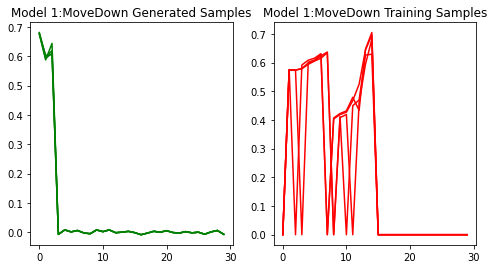

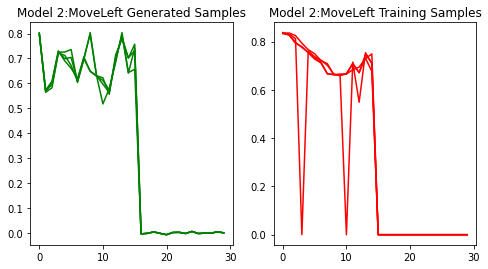

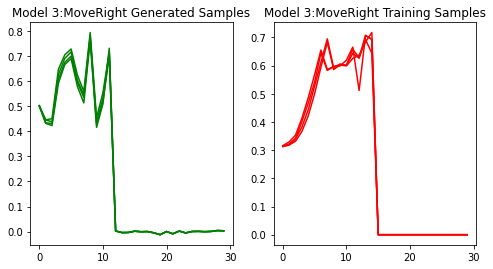

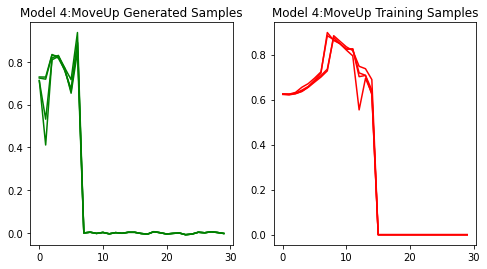

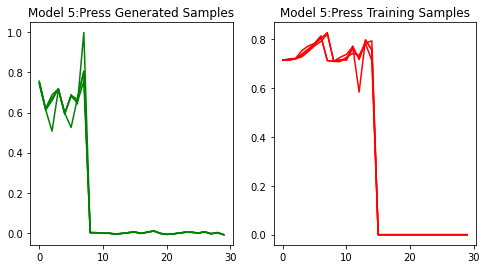

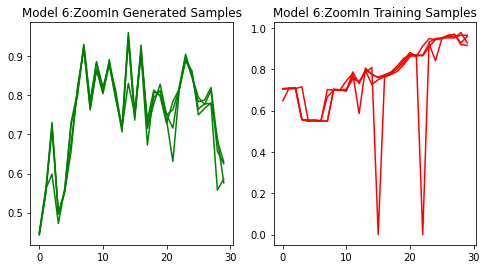

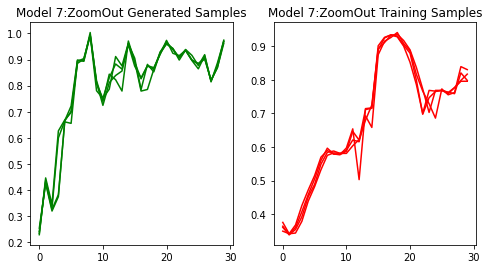

In [ ]:
with open('Model_contents' , 'rb') as files:
    models = pickle.load(files)
for i in range(len(gestures)):
    fig = plt.figure(figsize=[8, 9])
    ax = fig.add_subplot(2, 2, 1)
    obs = fig.add_subplot(2, 2, 2)
    ax.plot(models[i].sample(30)[0], color='g', linestyle="-")
    obs.plot(np.array(x_train)[i][0].reshape(30,4), color='r', linestyle="-")
    generated_samples = 'Model '+str(i+1)+':'+list(gestures)[i]+' Generated Samples'
    training_samples = 'Model '+str(i+1)+':'+list(gestures)[i]+' Training Samples'
    ax.title.set_text(generated_samples)
    obs.title.set_text(training_samples)

## The Forwards Algorithm

In [ ]:
print(models[1].n_components)
print(models[1].n_features)

7
4


In [ ]:
import math
def log_gaussian(o, mu, r):
    compute = (- 0.5 * np.log(r) - np.divide(
        np.square(o - mu), 2 * r) - 0.5 * np.log(2 * math.pi)).sum()
    return compute

In [ ]:
from scipy.stats import multivariate_normal

def alpha(k):
  emmisionprob=log_gaussian(,np.array(models[k].means_),(models[k].covars_))
  #emmisionprob=multivariate_normal.pdf(((models[k].transmat_)[:][:4]).flatten(), mean=np.array(models[k].means_).flatten(), cov=np.sqrt(np.abs(models[k].covars_)).flatten())
  alpha_cap = np.multiply(models[k].startprob_, np.transpose(emmisionprob))[0]
  alpha_values = np.divide(alpha_cap, sum(alpha_cap))

  for j in range(1,k+1):
    alpha_cap = np.multiply(np.dot(alpha_values, models[k].transmat_), np.transpose(emmisionprob))[0]
    alpha_values = np.divide(alpha_cap, sum(alpha_cap))

  return alpha_values

In [ ]:
#print(gestures)
#print(models[1].n_components)
#print(models[1].n_features)
print("startprob_\n",models[2].startprob_)
#print(models[1].means_)
#print(models[1].covars_)
print("\n transmat_ \n",models[2].transmat_)
#print(models[1].monitor_)
#print(models[1].get_stationary_distribution())


startprob_
 [4.00040495e-006 0.00000000e+000 5.83284863e-009 2.91119470e-014
 3.54677790e-004 9.99641316e-001 9.11383407e-160]

 transmat_ 
 [[2.28330494e-002 2.26196918e-002 5.37949474e-005 2.26331221e-002
  5.58238812e-001 3.50986873e-001 2.26346568e-002]
 [5.16100944e-045 1.00000000e+000 1.66714920e-066 6.27139813e-048
  1.06343021e-042 1.35969304e-027 2.10519630e-095]
 [6.43712668e-003 5.96403899e-001 1.16306658e-002 1.37384790e-005
  5.29532725e-002 3.32560911e-001 3.87005977e-007]
 [1.39913244e-002 6.07707080e-002 4.10053389e-002 5.94803349e-002
  1.79023801e-001 5.85363642e-001 6.03648505e-002]
 [2.69592063e-001 9.01116327e-042 2.71098327e-001 5.31558041e-002
  2.79409663e-001 1.24935808e-001 1.80833355e-003]
 [1.42023583e-002 1.05443794e-014 6.46674716e-002 2.14497311e-002
  2.03498846e-001 6.87907170e-001 8.27442340e-003]
 [4.49104946e-004 2.00000000e-001 2.20631300e-001 2.70362957e-010
  5.43306093e-001 3.56135017e-002 3.43637121e-158]]


In [ ]:
filterResults = np.array([alpha(j) for j in range(len(x_train))])
print(filterResults)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


ValueError: ignored

In [ ]:
print(models[1].means_.shape)
print(models[1].covars_.shape)
print(len(x_train))